# CIFAR-10

http://www.cs.toronto.edu/~kriz/cifar.html   
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import seaborn as sns

Loading data from keras datasets

In [2]:
cifar10_data = keras.datasets.cifar10
(X_train, y_train), (X_test, y_test) = cifar10_data.load_data()

In [3]:
print(f'train images size: {X_train.shape}, train labels size {y_train.shape}')
print(f'test dataset size: {X_test.shape}, test labels size {y_test.shape}')

train images size: (50000, 32, 32, 3), train labels size (50000, 1)
test dataset size: (10000, 32, 32, 3), test labels size (10000, 1)


In [4]:
categories = np.unique(y_train)
print(f'number of unique labels: {categories.shape[0]}\n')
print(f'labels {categories}')

number of unique labels: 10

labels [0 1 2 3 4 5 6 7 8 9]


In [5]:
# label names from https://keras.io/api/datasets/fashion_mnist/
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Display some examples from the dataset

In [6]:
def display_img(image, label):
    plt.grid(False)
    plt.title(label)
    plt.imshow(image)
    plt.xlabel(label)
    plt.axis('off')

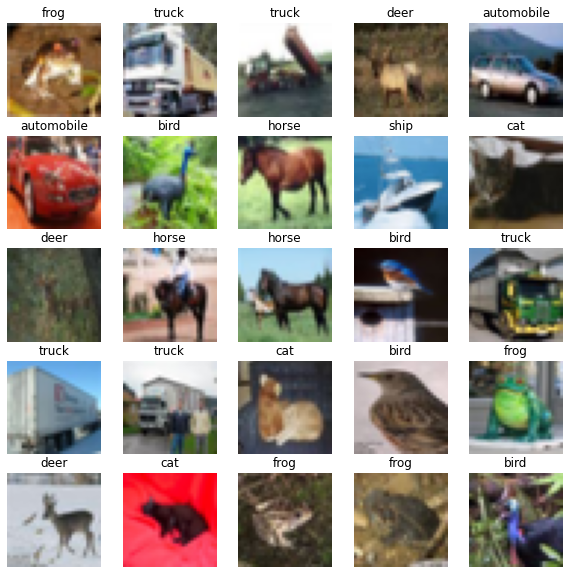

In [7]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(zip(X_train[:25], y_train[:25])):
    plt.subplot(5,5,i+1)
    display_img(image, label_names[label[0]])

In [8]:
x_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
x_test  = X_test.reshape(X_test.shape[0], X_test.shape[1]* X_test.shape[2] * X_test.shape[3])
print(x_train.shape)
print(x_test.shape)

(50000, 3072)
(10000, 3072)


**Building a Scikit Learn Pipeline**

I need to build a pipeline to process data and try different classifiers to find which best fits the problem. In order to include different classifiers in the pipeline, we create a customizable classifier function, include the classifier as a hyperparameter to be optimized using cross-validated grid-search (GridSearchCV).

In [9]:
class myClassifier(BaseEstimator):

    def __init__(self, estimator = SGDClassifier()):

        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

pipeline: std_scale pixel values, feature decomposition using pca, custom classifier. 

In [10]:
pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('clf', myClassifier()),
])

Grid search cross validation on 7 different models, for 5 folds.

In [11]:
param_grid = [
    {
        'clf__estimator': [SGDClassifier()],
    },
    {
        'clf__estimator': [KNeighborsClassifier()],
        'clf__estimator__n_neighbors': [3, 4],
    },
    {
        'clf__estimator': [DecisionTreeClassifier()],
        'clf__estimator__criterion': ['entropy','gini'],
    },
    {
        'clf__estimator': [RandomForestClassifier()],
        'clf__estimator__criterion': ['entropy','gini'],
    },
]

In [12]:
gscv = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=8, return_train_score=False, verbose=3)
gscv.fit(x_train, y_train[:,0])

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 3/5] END clf__estimator=KNeighborsClassifier(), clf__estimator__n_neighbors=3;, score=0.345 total time=  44.6s
[CV 4/5] END clf__estimator=KNeighborsClassifier(), clf__estimator__n_neighbors=3;, score=0.342 total time=  38.3s
[CV 2/5] END clf__estimator=KNeighborsClassifier(), clf__estimator__n_neighbors=4;, score=0.350 total time=  40.6s
[CV 5/5] END clf__estimator=KNeighborsClassifier(), clf__estimator__n_neighbors=4;, score=0.350 total time=  41.5s
[CV 3/5] END clf__estimator=DecisionTreeClassifier(), clf__estimator__criterion=entropy;, score=0.251 total time= 2.3min
[CV 1/5] END clf__estimator=RandomForestClassifier(), clf__estimator__criterion=gini;, score=0.433 total time= 1.8min
[CV 4/5] END clf__estimator=RandomForestClassifier(), clf__estimator__criterion=gini;, score=0.424 total time= 1.7min
[CV 3/5] END ....clf__estimator=SGDClassifier();, score=0.280 total time= 3.1min
[CV 4/5] END clf__estimator=DecisionTreeCl

/users/syassien/.conda/envs/syEnv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.95)),
                                       ('clf', myClassifier())]),
             n_jobs=8,
             param_grid=[{'clf__estimator': [SGDClassifier()]},
                         {'clf__estimator': [KNeighborsClassifier()],
                          'clf__estimator__n_neighbors': [3, 4]},
                         {'clf__estimator': [DecisionTreeClassifier()],
                          'clf__estimator__criterion': ['entropy', 'gini']},
                         {'clf__estimator': [RandomForestClassifier()],
                          'clf__estimator__criterion': ['entropy', 'gini']}],
             verbose=3)

**Results**   

In [14]:
gscv.cv_results_

{'mean_fit_time': array([191.58782463,  36.17082276,  32.54867826, 137.60124145,
         49.58528943, 461.29928765, 103.43143225]),
 'std_fit_time': array([11.54720271,  2.87358805,  0.62877526,  2.25486206,  0.56131596,
         7.78482885,  2.49216653]),
 'mean_score_time': array([0.46624994, 6.50061841, 9.19483085, 0.4706646 , 0.48990054,
        0.85438232, 0.8930335 ]),
 'std_score_time': array([0.01206702, 0.18472411, 0.31712014, 0.0113589 , 0.01478036,
        0.04089084, 0.02430346]),
 'param_clf__estimator': masked_array(data=[SGDClassifier(), KNeighborsClassifier(),
                    KNeighborsClassifier(), DecisionTreeClassifier(),
                    DecisionTreeClassifier(), RandomForestClassifier(),
                    RandomForestClassifier()],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_clf__estimator__n_neighbors': masked_array(data=[--, 3, 4, --, --, --, --],
              mask=[ 

In [15]:
final_model = gscv.best_estimator_
final_model

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('clf', myClassifier(estimator=RandomForestClassifier()))])

The best estimator is the RandomForestClassifier()

In [16]:
import pickle

loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
loaded_model

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95)),
                ('clf', myClassifier(estimator=RandomForestClassifier()))])

In [17]:
y_pred = loaded_model.predict(x_test)
acc = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy on test data = {acc}')

Accuracy on test data = 0.4387


Comparing models

In [19]:
results_df = pd.DataFrame(gscv.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
RandomForestClassifier()_gini,"{'clf__estimator': RandomForestClassifier(), '...",1,0.42984,0.003514
RandomForestClassifier()_entropy,"{'clf__estimator': RandomForestClassifier(), '...",2,0.42116,0.004228
KNeighborsClassifier()_4,"{'clf__estimator': KNeighborsClassifier(), 'cl...",3,0.35144,0.003399
KNeighborsClassifier()_3,"{'clf__estimator': KNeighborsClassifier(), 'cl...",4,0.34434,0.003280
SGDClassifier(),{'clf__estimator': SGDClassifier()},5,0.28420,0.007559
DecisionTreeClassifier()_entropy,"{'clf__estimator': DecisionTreeClassifier(), '...",6,0.25274,0.005040
DecisionTreeClassifier()_gini,"{'clf__estimator': DecisionTreeClassifier(), '...",7,0.25152,0.005315


RandomForestClassifier() has the highesr mean test score while DecisionTreeClassifier() has the lowest out of all models

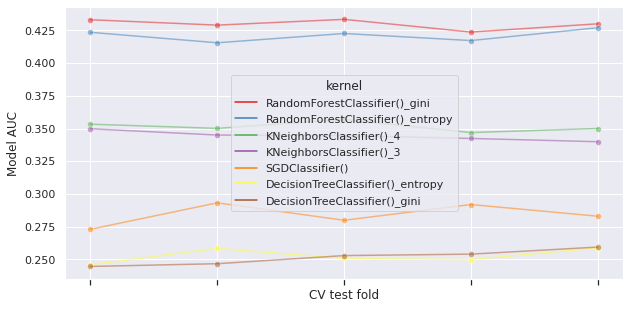

In [56]:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html
# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.set(rc = {'figure.figsize':(10,5)})
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

Our best estimator performance is far from impressive, a convolutional neural network will be better suited for this problem. 

In [60]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)               

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, 
                    validation_data=(X_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6818 - accuracy: 0.7645 - val_loss: 1.0408 - val_accuracy: 0.6732
Epoch 2/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6463 - accuracy: 0.7750 - val_loss: 1.0668 - val_accuracy: 0.6729
Epoch 3/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6097 - accuracy: 0.7896 - val_loss: 1.0905 - val_accuracy: 0.6734
Epoch 4/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5925 - accuracy: 0.7937 - val_loss: 1.1287 - val_accuracy: 0.6699
Epoch 5/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5625 - accuracy: 0.8052 - val_loss: 1.1442 - val_accuracy: 0.6588
Epoch 6/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5464 - accuracy: 0.8122 - val_loss: 1.1387 - val_accuracy: 0.6714
Epoch 7/20
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5227 - accuracy: 0.8198 - val_loss: 1.1999 - val_accuracy:

313/313 - 1s - loss: 1.5767 - accuracy: 0.6573


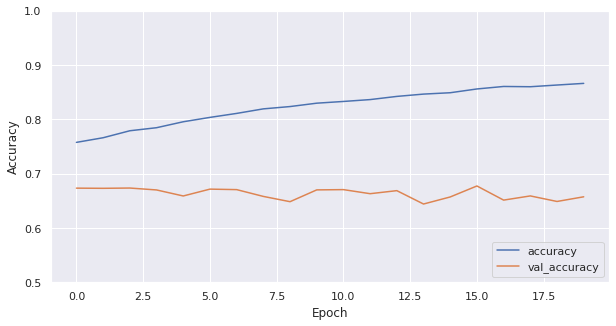

In [68]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

The CNN model performed better than the random forest classifier. We can do way better if we train for more epochs, use a more complicated network, or use a pre-trained network. 